In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from livelossplot import PlotLossesKerasTF
from IPython.display import SVG, Image
import tensorflow as tf
import tensorflow.keras.utils as ku 
import numpy as np 
import os

In [9]:
tokenizer = Tokenizer()
data = open('./sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [19]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [20]:
# Define a Callback class that stops training once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callback_95 = myCallback()

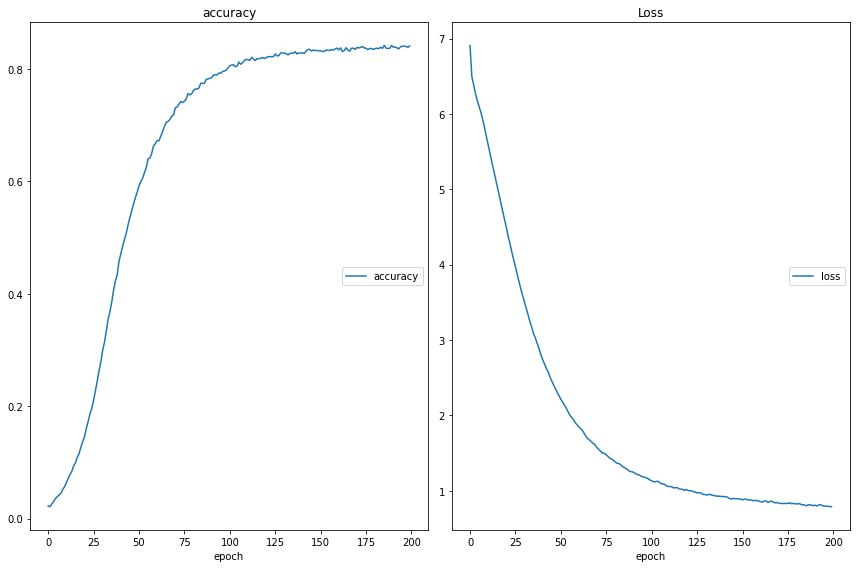

accuracy
	accuracy         	 (min:    0.021, max:    0.842, cur:    0.841)
Loss
	loss             	 (min:    0.789, max:    6.909, cur:    0.789)
484/484 [==============================] - 6s 13ms/step - loss: 0.7886 - accuracy: 0.8407


In [21]:
callbacks = [PlotLossesKerasTF(), callback_95]
history = model.fit(predictors, label, epochs=200, callbacks=callbacks, verbose=1)

In [40]:
# seed_text = "Help me Obi Wan Kenobi, you're my only hope"
seed_text = "Hello beautiful flower, you make me smile "

next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
# print(seed_text)

In [41]:
seed_text

"Hello beautiful flower, you make me smile  would all my mind that gracious doth shown free ' live new must thee die not dead am gone kind alone acquainted of thee great shame deny some grow new can know thee not still keep such faith thou know not so mine eye awake ' bold swear 'tis me a brand acquainted fill'd and new dyed sit dyed seen forth mine friend glory grace thee part good worth another only prove me acquainted still not tell thy near ' knit cured i know thee so be belong convertest ' bold acquainted left to thee take it not more remains"